In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

from scipy.stats import chi2_contingency
from itertools import combinations

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.max_colwidth = 1000

In [138]:

df = pd.read_csv('TruthSeeker.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print("Shape: ", df.shape)    
print("Info: ", df.info())
print("first 5 lines: ", df.head())
# print("Describe: ", df.describe())

#original tweet features
original_tweet_features = df.iloc[:, 1:4].copy() #de la 1 la 4 cu 2 in 2: gen [statement, BinaryNumTarget, tweet] va lua doar [statement si tweet
# handcrafted features
meta_data_features = df.iloc[:, 4:22].copy()
text_features = df.iloc[:, 22:46].copy()
lexical_features = df.iloc[:, 46:].copy()

# target output feature
target = df[["majority_target"]].copy()


Shape:  (134198, 63)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 63 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   majority_target         134198 non-null  bool   
 1   statement               134198 non-null  object 
 2   BinaryNumTarget         134198 non-null  float64
 3   tweet                   134198 non-null  object 
 4   followers_count         134198 non-null  float64
 5   friends_count           134198 non-null  float64
 6   favourites_count        134198 non-null  float64
 7   statuses_count          134198 non-null  float64
 8   listed_count            134198 non-null  float64
 9   following               134198 non-null  float64
 10  embeddings              134198 non-null  object 
 11  BotScore                134198 non-null  float64
 12  BotScoreBinary          134198 non-null  float64
 13  cred                    134198 non-null  float64
 14 

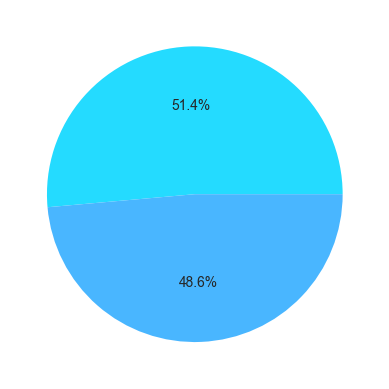

In [139]:
plt.pie(target["majority_target"].value_counts(), colors = sns.color_palette("cool"), autopct = '%1.1f%%')
pass

In [140]:
data = pd.concat([original_tweet_features, meta_data_features, lexical_features, text_features, target], axis=1)

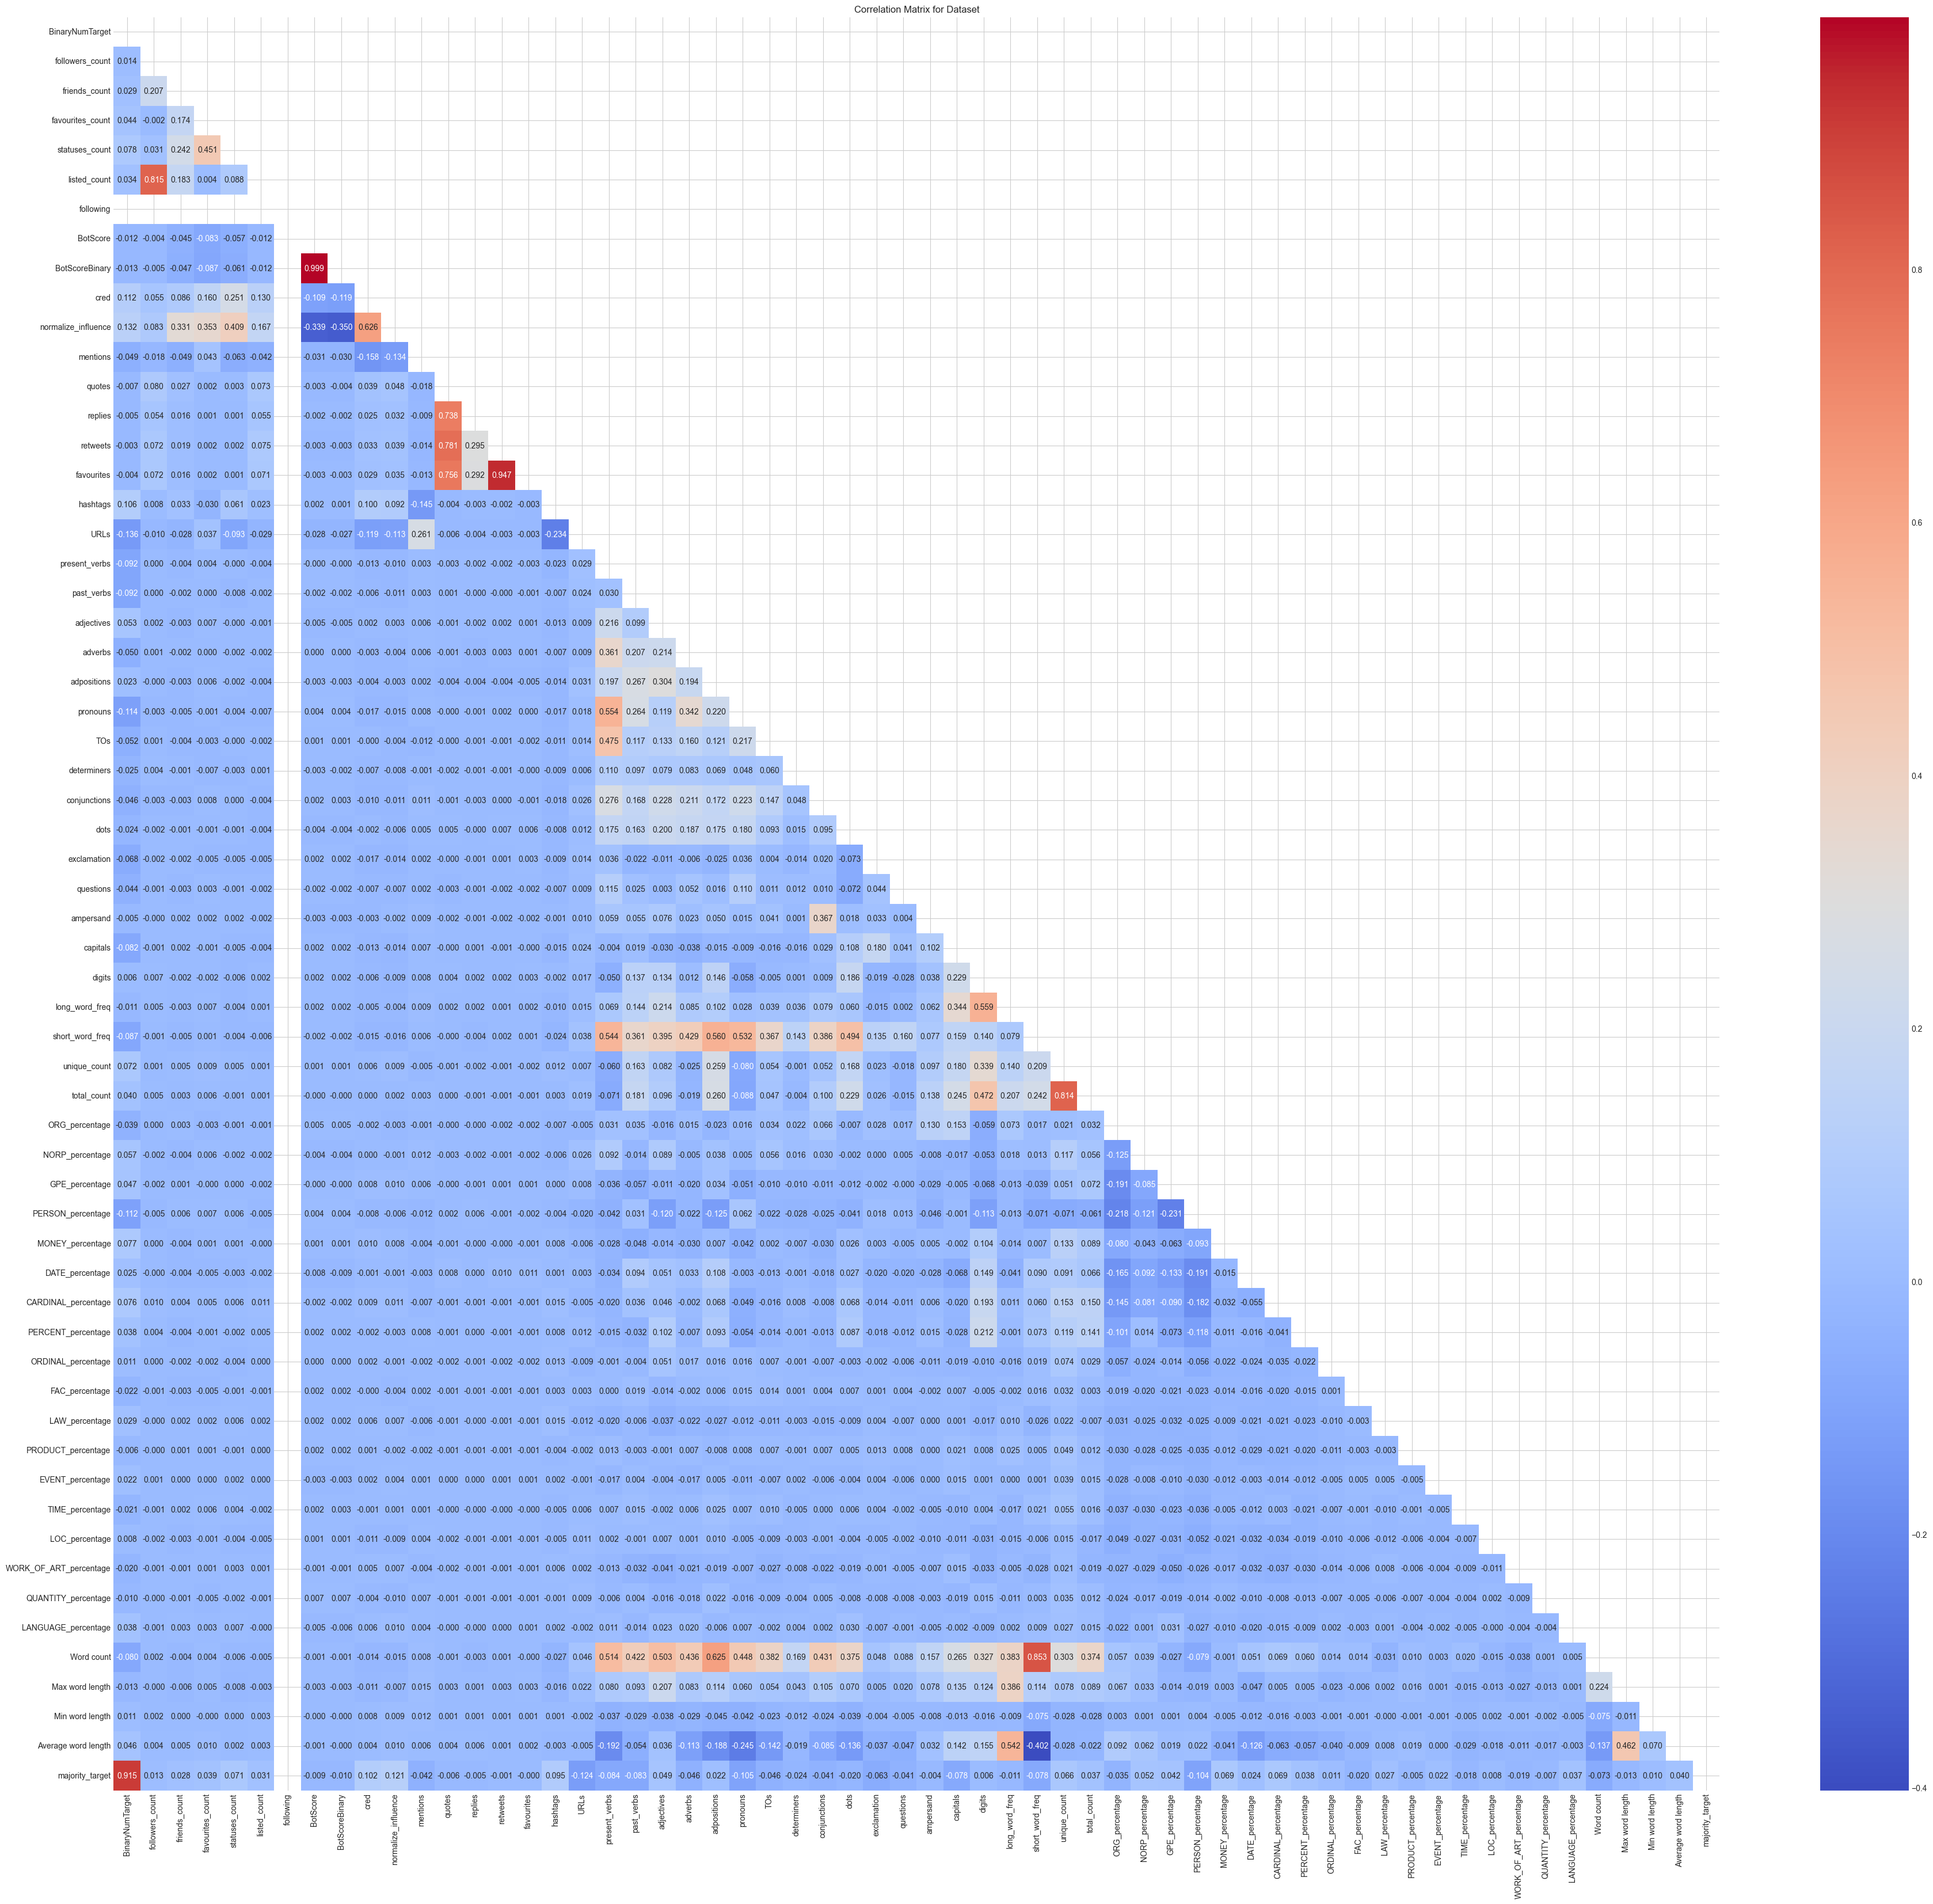

In [141]:
corr_mat = data.corr(numeric_only=True, method="pearson")
mask = np.triu(np.ones_like(corr_mat, dtype=np.bool))
 #Correlation
plt.figure(figsize=(45,40))
sns.heatmap(data=corr_mat, mask = mask, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Correlation Matrix for Dataset")
plt.show()

In [142]:
strong_correlations = corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

corr_df = strong_correlations.reset_index()
corr_df.columns = ['Feature 1', 'Feature 2', 'Correlation']

print("="*80)
print("STRONG CORRELATIONS (|correlation| > 0.5)")
print("="*80)
print(f"\nTotal pairs found: {len(corr_df)}\n")
print(corr_df.to_string(index=False))
print("\n" + "="*80)

STRONG CORRELATIONS (|correlation| > 0.5)

Total pairs found: 19

      Feature 1           Feature 2  Correlation
       BotScore      BotScoreBinary     0.999169
       retweets          favourites     0.947228
BinaryNumTarget     majority_target     0.914583
short_word_freq          Word count     0.853101
followers_count        listed_count     0.815270
   unique_count         total_count     0.813542
         quotes            retweets     0.781421
         quotes          favourites     0.756364
         quotes             replies     0.737935
           cred normalize_influence     0.626198
    adpositions          Word count     0.624694
    adpositions     short_word_freq     0.560209
         digits      long_word_freq     0.558840
  present_verbs            pronouns     0.554039
  present_verbs     short_word_freq     0.543649
 long_word_freq Average word length     0.541591
       pronouns     short_word_freq     0.531958
  present_verbs          Word count     0.514472
   

In [143]:
meta_data_features.drop(columns=["following", "retweets", "BotScoreBinary", "embeddings"], axis=1, inplace=True) #toate valorile erau 0.0
text_features.drop(columns=["Word count", "Max word length", "Min word length", "Average word length"], inplace=True)
original_tweet_features.drop(columns=["BinaryNumTarget"], inplace=True)

In [144]:
data = pd.concat([original_tweet_features, meta_data_features, lexical_features, text_features, target], axis=1)

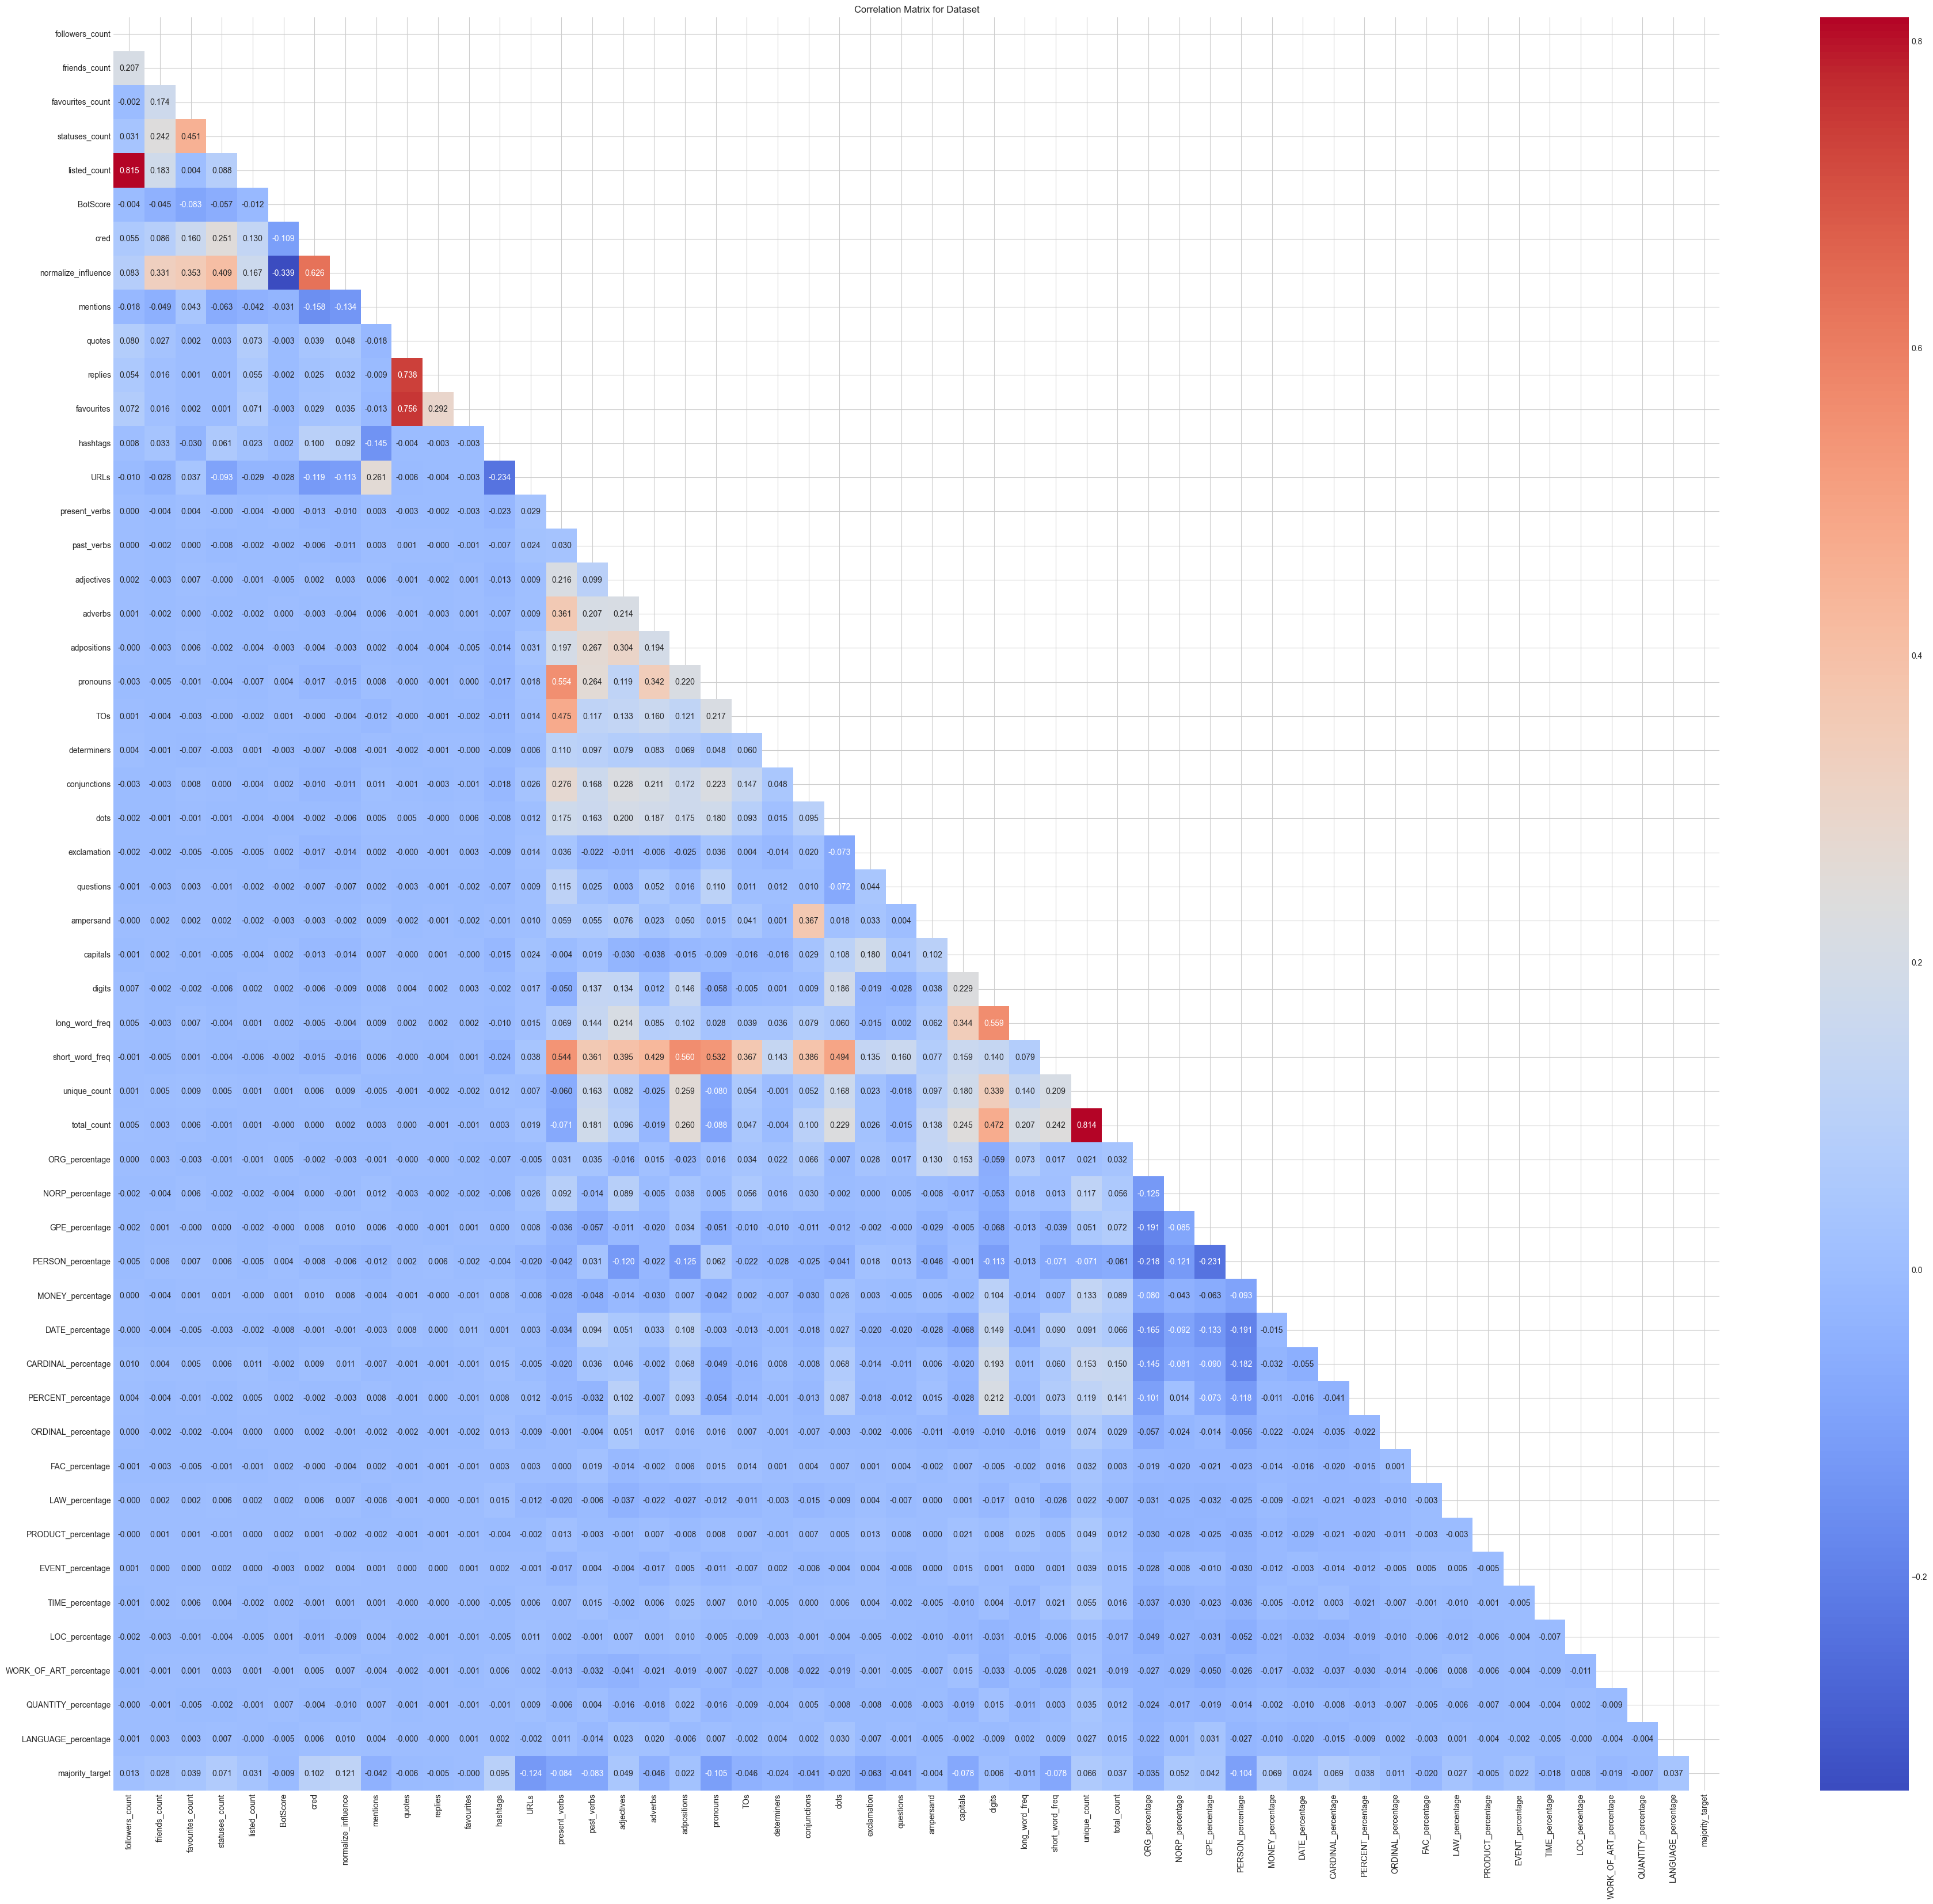

In [145]:
corr_mat = data.corr(numeric_only=True, method="pearson")
mask = np.triu(np.ones_like(corr_mat, dtype=np.bool))
 #Correlation
plt.figure(figsize=(45,40))
sns.heatmap(data=corr_mat, mask=mask, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Correlation Matrix for Dataset")
plt.show()

In [146]:
strong_correlations = corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

corr_df = strong_correlations.reset_index()
corr_df.columns = ['Feature 1', 'Feature 2', 'Correlation']

print(f"\nTotal pairs found: {len(corr_df)}\n")
print(corr_df.to_string(index=False))


Total pairs found: 10

      Feature 1           Feature 2  Correlation
followers_count        listed_count     0.815270
   unique_count         total_count     0.813542
         quotes          favourites     0.756364
         quotes             replies     0.737935
           cred normalize_influence     0.626198
    adpositions     short_word_freq     0.560209
         digits      long_word_freq     0.558840
  present_verbs            pronouns     0.554039
  present_verbs     short_word_freq     0.543649
       pronouns     short_word_freq     0.531958


In [147]:
plt.style.use('seaborn-v0_8-whitegrid')

ner_columns = [col for col in text_features.columns if col.endswith('_percentage')]
clean_ner_columns = [col.replace('_percentage', '') for col in ner_columns]
column_map = dict(zip(ner_columns, clean_ner_columns))

# Extract overall NER data (for Viz 1)
ner_data = data[ner_columns].copy()
clean_ner_data = ner_data.rename(columns=lambda x: x.replace('_percentage', ''))

# Extract NER data with target (for Viz 2)
ner_with_target = data[ner_columns + ['majority_target']].copy()
true_tweets = ner_with_target[ner_with_target['majority_target'] == True]
false_tweets = ner_with_target[ner_with_target['majority_target'] == False]
N_true = len(true_tweets)
N_false = len(false_tweets)


# --- Global Metric Calculation ---

# 1. Metrics for Overall NER Analysis (Viz 1)
tweet_counts = (clean_ner_data > 0).sum()
avg_percentages = (clean_ner_data > 0).sum() / len(clean_ner_data) * 100

# 2. Metrics for Target Comparison (Viz 2)
true_counts = (true_tweets[ner_columns] > 0).sum().rename(column_map)
false_counts = (false_tweets[ner_columns] > 0).sum().rename(column_map)
true_pct = (true_counts / N_true) * 100
false_pct = (false_counts / N_false) * 100
true_avg = true_tweets[ner_columns].mean().rename(column_map) * 100
false_avg = false_tweets[ner_columns].mean().rename(column_map) * 100

# Define Sort Order (by total count across both classes, used for Viz 2 and Plot 4 of Viz 1)
total_counts = true_counts + false_counts
sort_order = total_counts.sort_values(ascending=True).index


# --- Reusable Plotting Functions ---

def create_horiz_bar_plot(ax, series, title, x_label, colors):
    """Generates a styled, labeled horizontal bar plot (for single series plots)."""
    series = series.sort_values(ascending=True)
    y_labels = series.index

    # Plot bars
    ax.barh(y_labels, series.values, color=colors)

    # Styling
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel(x_label, fontsize=11)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='x', alpha=0.5, linestyle='--')
    
    # Add labels to the bars
    is_percent = 'Percentage' in x_label
    for i, val in enumerate(series.values):
        label = f'{val:,.0f}' if not is_percent else f'{val:.2f}%'
        ax.text(val, i, label, va='center', ha='left', fontsize=9, fontweight='semibold', 
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

def plot_grouped_barh(ax, true_data, false_data, sort_order, title, x_label, format_string, color_true, color_false):
    """Generates a styled grouped horizontal bar plot (for True vs False comparison)."""
    true_sorted = true_data[sort_order]
    false_sorted = false_data[sort_order]

    x = np.arange(len(sort_order))
    width = 0.35

    ax.barh(x - width/2, true_sorted.values, width, label='True Tweets', color=color_true, alpha=0.8)
    ax.barh(x + width/2, false_sorted.values, width, label='False Tweets', color=color_false, alpha=0.8)

    ax.set_yticks(x)
    ax.set_yticklabels(sort_order, fontsize=10)
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.legend(fontsize=10, loc='lower right')
    ax.grid(axis='x', alpha=0.5, linestyle='--')
    
    # Optional: Add value labels for better readability
    for i, (t_val, f_val) in enumerate(zip(true_sorted.values, false_sorted.values)):
        t_pos = t_val + np.max(total_counts.values) * 0.01 if x_label == 'Number of Tweets' else t_val + 0.1
        f_pos = f_val + np.max(total_counts.values) * 0.01 if x_label == 'Number of Tweets' else f_val + 0.1
        
        ax.text(t_pos, i - width/2, format_string.format(t_val), va='center', ha='left', fontsize=7.5, fontweight='semibold')
        ax.text(f_pos, i + width/2, format_string.format(f_val), va='center', ha='left', fontsize=7.5, fontweight='semibold')

def plot_difference_barh(ax, true_data, false_data, sort_order, title, x_label):
    """Generates a styled horizontal bar plot showing the difference (True - False)."""
    difference = (true_data - false_data)[sort_order]
    
    colors = ['#2ecc71' if val >= 0 else '#e74c3c' for val in difference.values]
    x = np.arange(len(sort_order))

    ax.barh(x, difference.values, color=colors, alpha=0.8)

    ax.set_yticks(x)
    ax.set_yticklabels(sort_order, fontsize=10)
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1) 
    ax.grid(axis='x', alpha=0.5, linestyle='--')

    # Add value labels
    for i, val in enumerate(difference.values):
        ha_align = 'left' if val >= 0 else 'right'
        offset = np.max(np.abs(difference.values)) * 0.01
        
        ax.text(val + offset * (1 if val >= 0 else -1), i, f'{val:+.2f}%', 
                 va='center', ha=ha_align, fontsize=7.5, fontweight='semibold')

/var/folders/2s/q86v619s3_g1crpyjj20lc9m0000gn/T/ipykernel_46325/2353293775.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(top_ner_data.values, labels=top_ner_data.columns,


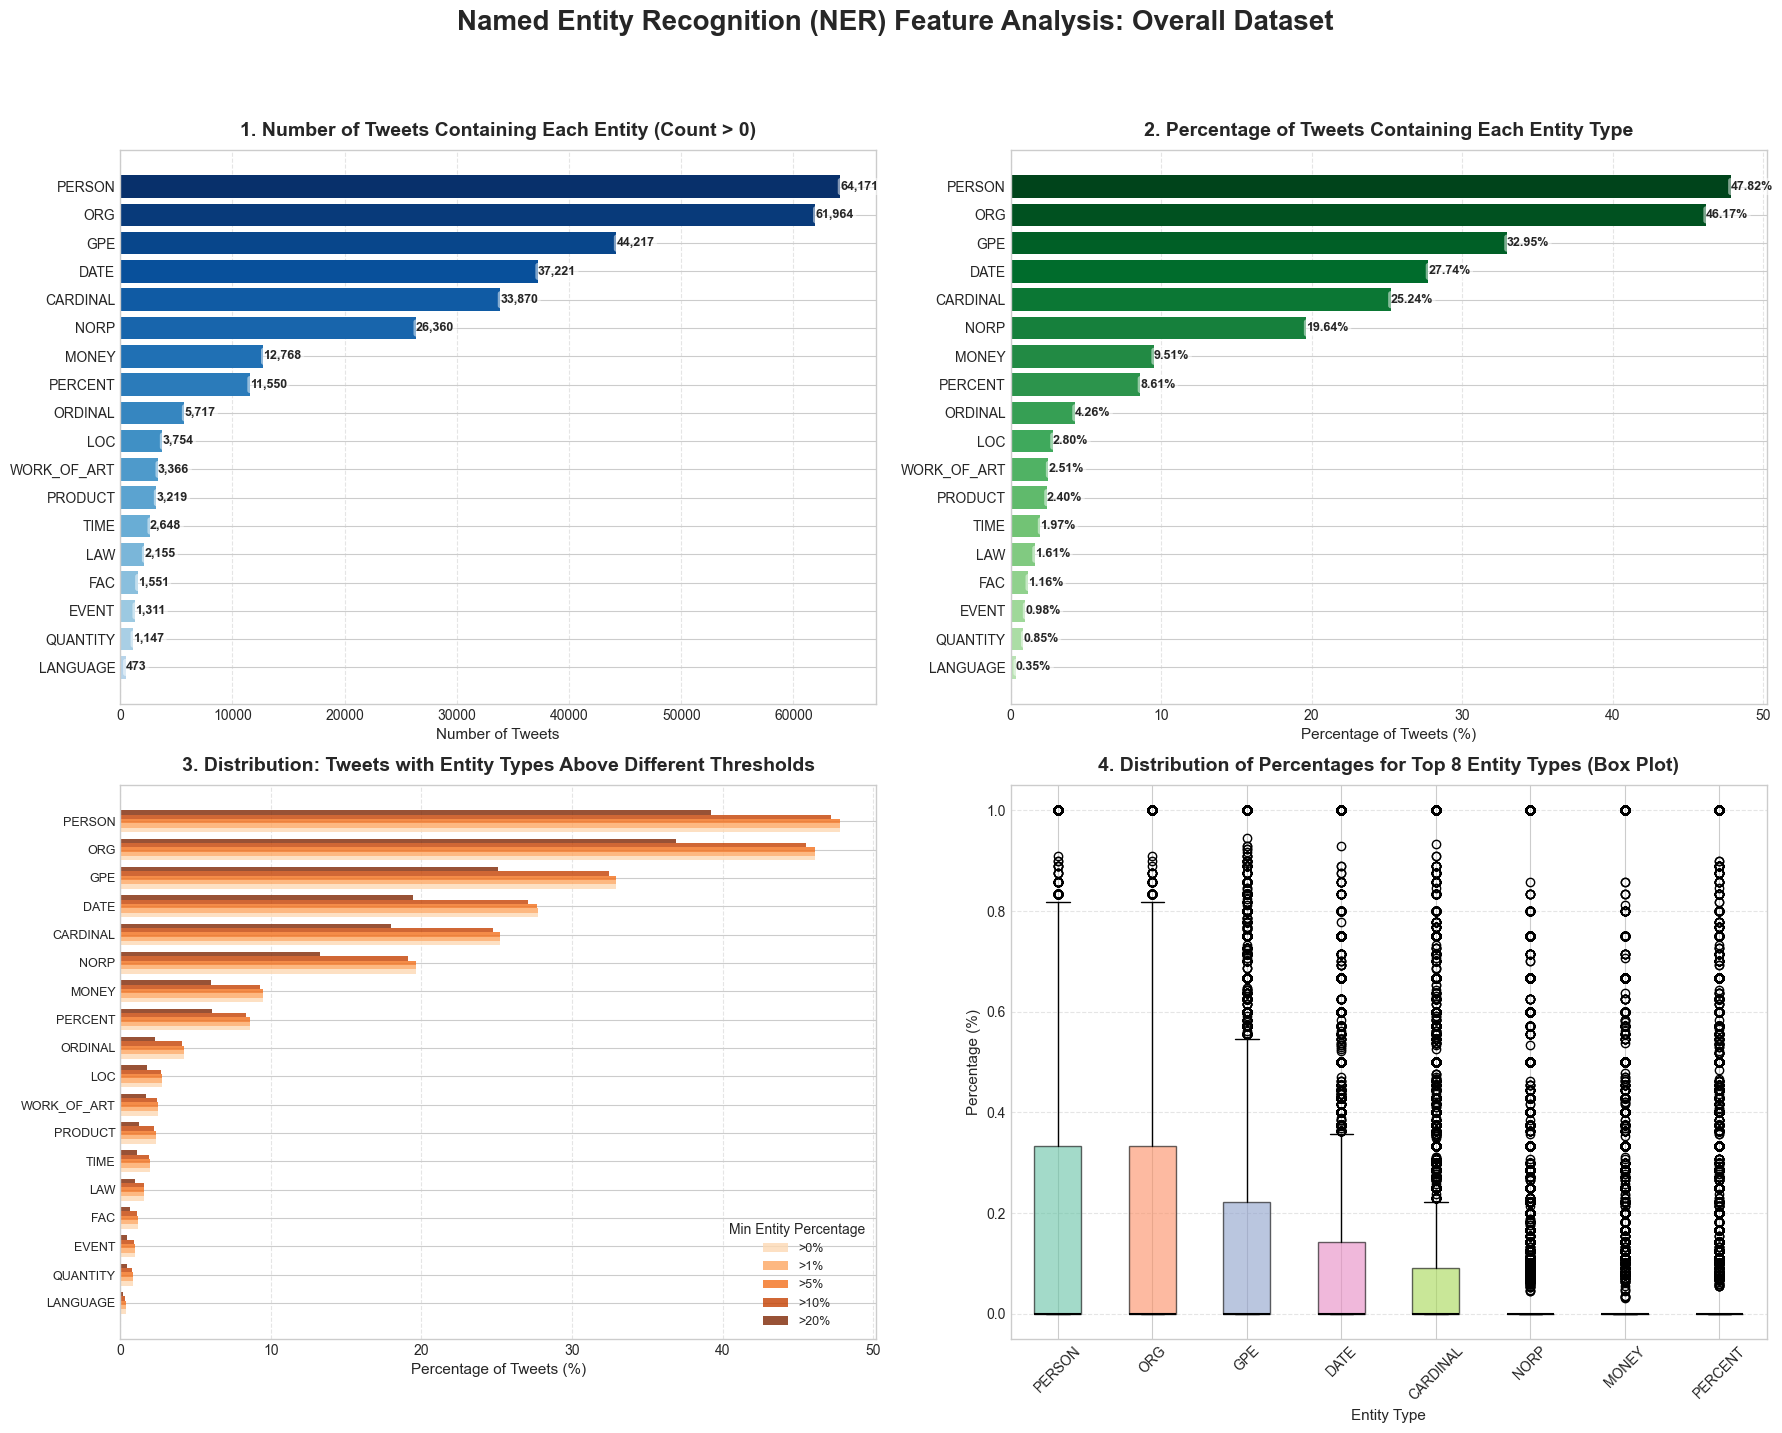

In [148]:
# --- 1. 4-in-1 Subplot Generation: Overall NER Analysis ---
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Named Entity Recognition (NER) Feature Analysis: Overall Dataset', 
             fontsize=20, fontweight='bold', y=1.02)
plt.subplots_adjust(hspace=0.4, wspace=0.3)


# --- Plot 1: Count of tweets containing each entity type (percentage > 0) ---
ax1 = axes[0, 0]
colors1 = plt.cm.Blues(np.linspace(0.3, 1, len(tweet_counts)))
create_horiz_bar_plot(
    ax1, tweet_counts, 
    '1. Number of Tweets Containing Each Entity (Count > 0)', 
    'Number of Tweets', colors1
)


# --- Plot 2: Percentage of tweets containing each entity type ---
ax2 = axes[0, 1]
colors2 = plt.cm.Greens(np.linspace(0.3, 1, len(avg_percentages)))
create_horiz_bar_plot(
    ax2, avg_percentages, 
    '2. Percentage of Tweets Containing Each Entity Type', 
    'Percentage of Tweets (%)', colors2
)


# --- Plot 3: Distribution: Percentage of tweets with each entity type above thresholds ---
ax3 = axes[1, 0]
thresholds = [0, 0.01, 0.05, 0.1, 0.2] 
threshold_labels = [f'>{t*100:.0f}%' for t in thresholds]

# Calculate percentage of tweets above each threshold for each entity
threshold_data_dict = {}
for col in clean_ner_columns:
    col_data = [(clean_ner_data[col] > t).sum() / len(clean_ner_data) * 100 for t in thresholds]
    threshold_data_dict[col] = col_data

threshold_df = pd.DataFrame.from_dict(
    threshold_data_dict, orient='index', columns=threshold_labels
).sort_values(by='>0%', ascending=True)

x = np.arange(len(threshold_df))
width = 1 / (len(thresholds) + 1.5) 
colors3 = plt.cm.Oranges(np.linspace(0.2, 1, len(thresholds)))

for i, label in enumerate(threshold_labels):
    ax3.barh(x + i*width, threshold_df[label].values, width, 
             label=label, color=colors3[i], alpha=0.8)

ax3.set_yticks(x + width * (len(thresholds)-1) / 2)
ax3.set_yticklabels(threshold_df.index, fontsize=9)
ax3.set_xlabel('Percentage of Tweets (%)', fontsize=11)
ax3.set_title('3. Distribution: Tweets with Entity Types Above Different Thresholds', 
              fontsize=14, fontweight='bold', pad=10)
ax3.legend(title='Min Entity Percentage', fontsize=9, title_fontsize=10, loc='lower right')
ax3.grid(axis='x', alpha=0.5, linestyle='--')


# --- Plot 4: Box plot showing distribution of percentages for top entity types ---
ax4 = axes[1, 1]
top_entities = avg_percentages.nlargest(8).index
top_ner_data = clean_ner_data[top_entities]

# Create box plot 
bp = ax4.boxplot(top_ner_data.values, labels=top_ner_data.columns, 
                 vert=True, patch_artist=True, medianprops=dict(color='black', linewidth=1.5))

ax4.set_ylabel('Percentage (%)', fontsize=11)
ax4.set_xlabel('Entity Type', fontsize=11)
ax4.set_title('4. Distribution of Percentages for Top 8 Entity Types (Box Plot)', 
              fontsize=14, fontweight='bold', pad=10)
ax4.tick_params(axis='x', rotation=45, labelsize=10)
ax4.grid(axis='y', alpha=0.5, linestyle='--')

# Color the boxes
colors4 = plt.cm.Set2(np.linspace(0, 1, len(bp['boxes'])))
for patch, color in zip(bp['boxes'], colors4):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

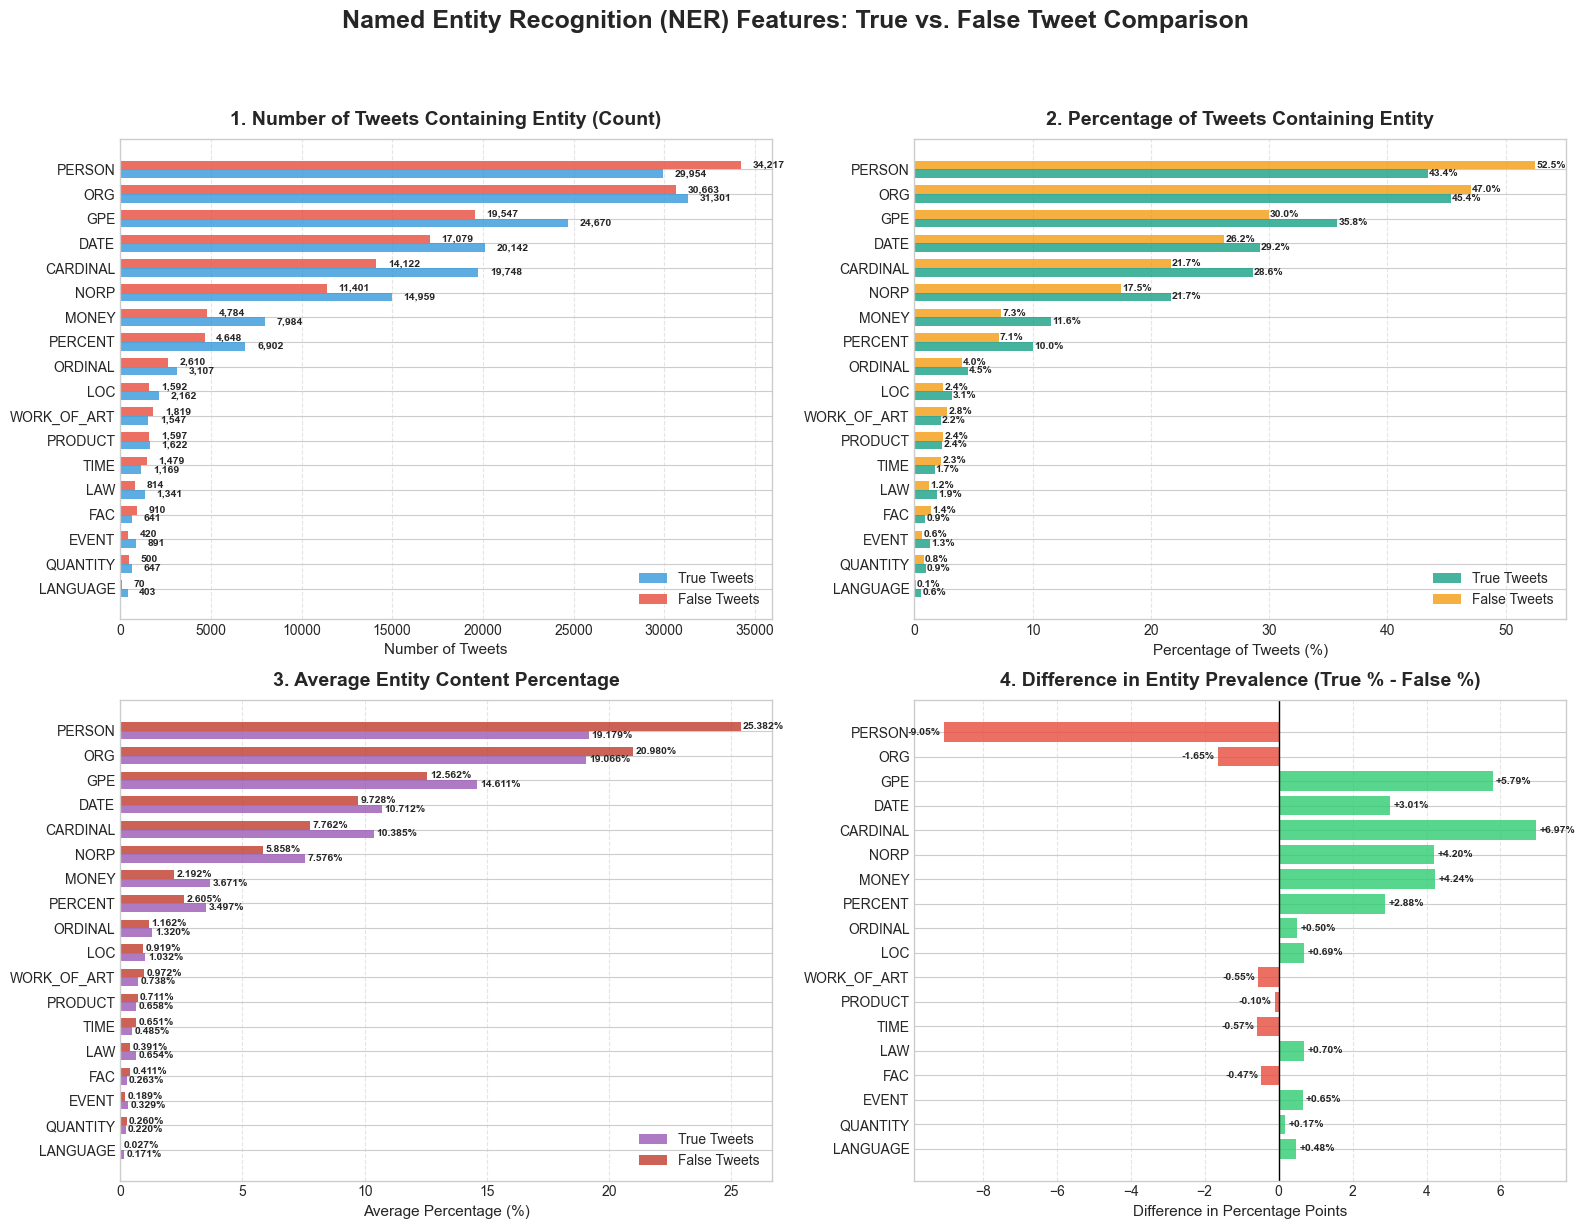

In [149]:
# --- 1. 4-in-1 Subplot Generation: True vs. False Comparison ---

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Named Entity Recognition (NER) Features: True vs. False Tweet Comparison', 
             fontsize=18, fontweight='bold', y=1.02)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. Count of tweets containing each entity type
plot_grouped_barh(
    axes[0, 0], true_counts, false_counts, sort_order,
    '1. Number of Tweets Containing Entity (Count)', 'Number of Tweets',
    '{:,}', '#3498db', '#e74c3c'
)

# 2. Percentage of tweets containing each entity type
plot_grouped_barh(
    axes[0, 1], true_pct, false_pct, sort_order,
    '2. Percentage of Tweets Containing Entity', 'Percentage of Tweets (%)',
    '{:.1f}%', '#16a085', '#f39c12'
)

# 3. Average percentage for each entity type
plot_grouped_barh(
    axes[1, 0], true_avg, false_avg, sort_order,
    '3. Average Entity Content Percentage', 'Average Percentage (%)',
    '{:.3f}%', '#9b59b6', '#c0392b'
)

# 4. Difference in percentage (True - False)
plot_difference_barh(
    axes[1, 1], true_pct, false_pct, sort_order,
    '4. Difference in Entity Prevalence (True % - False %)', 'Difference in Percentage Points'
)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [150]:
# Analyze percentage of zeros in numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Calculate zero percentages for each numerical column
zero_stats = []
for col in numerical_cols:
    total_count = len(data[col])
    zero_count = (data[col] == 0).sum()
    zero_percentage = (zero_count / total_count) * 100
    non_zero_count = total_count - zero_count
    
    zero_stats.append({
        'Column': col,
        'Total Values': total_count,
        'Zero Count': zero_count,
        'Non-Zero Count': non_zero_count,
        'Zero Percentage (%)': zero_percentage
    })

zero_df = pd.DataFrame(zero_stats)
zero_df = zero_df.sort_values('Zero Percentage (%)', ascending=False).reset_index(drop=True)

# Display the table
print("="*100)
print("ZERO VALUE ANALYSIS: Percentage of Zeros in Numerical Columns")
print("="*100)
print(f"\nTotal numerical columns analyzed: {len(numerical_cols)}")
print(f"Total rows in dataset: {len(data):,}\n")
print(zero_df.to_string(index=False))



ZERO VALUE ANALYSIS: Percentage of Zeros in Numerical Columns

Total numerical columns analyzed: 51
Total rows in dataset: 134,198

                Column  Total Values  Zero Count  Non-Zero Count  Zero Percentage (%)
   LANGUAGE_percentage        134198      133725             473            99.647536
   QUANTITY_percentage        134198      133051            1147            99.145293
      EVENT_percentage        134198      132887            1311            99.023085
        FAC_percentage        134198      132647            1551            98.844245
        LAW_percentage        134198      132043            2155            98.394164
       TIME_percentage        134198      131550            2648            98.026796
    PRODUCT_percentage        134198      130979            3219            97.601306
WORK_OF_ART_percentage        134198      130832            3366            97.491766
        LOC_percentage        134198      130444            3754            97.202641
    ORDI

In [151]:
def filter_zero_sparse_columns(df: pd.DataFrame, threshold: float = 70.0) -> pd.DataFrame:
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cols_to_drop = []
    print("="*80)
    for col in numerical_cols:
        total_count = len(df[col])
        zero_count = (df[col]==0).sum()
        zero_percentage = (zero_count / total_count) * 100
        
        if zero_percentage > threshold:
            cols_to_drop.append(col)
            print(f"  DROPPED: '{col}' ({zero_percentage:.2f}% zeros > {threshold}%)")
    if cols_to_drop:
        df_filtered = df.drop(columns=cols_to_drop)
    else:
        df_filtered = df.copy()
    return df_filtered

In [152]:
meta_data_features = filter_zero_sparse_columns(meta_data_features, threshold=70.0)
text_features = filter_zero_sparse_columns(text_features, threshold=70.0)
lexical_features = filter_zero_sparse_columns(lexical_features, threshold=70.0)

print("Meta Data Columns:", meta_data_features.columns.tolist())
print("Text Features Columns:", text_features.columns.tolist())
print("Lexical Features Columns:", lexical_features.columns.tolist())

  DROPPED: 'quotes' (95.71% zeros > 70.0%)
  DROPPED: 'hashtags' (92.97% zeros > 70.0%)
  DROPPED: 'NORP_percentage' (80.36% zeros > 70.0%)
  DROPPED: 'MONEY_percentage' (90.49% zeros > 70.0%)
  DROPPED: 'DATE_percentage' (72.26% zeros > 70.0%)
  DROPPED: 'CARDINAL_percentage' (74.76% zeros > 70.0%)
  DROPPED: 'PERCENT_percentage' (91.39% zeros > 70.0%)
  DROPPED: 'ORDINAL_percentage' (95.74% zeros > 70.0%)
  DROPPED: 'FAC_percentage' (98.84% zeros > 70.0%)
  DROPPED: 'LAW_percentage' (98.39% zeros > 70.0%)
  DROPPED: 'PRODUCT_percentage' (97.60% zeros > 70.0%)
  DROPPED: 'EVENT_percentage' (99.02% zeros > 70.0%)
  DROPPED: 'TIME_percentage' (98.03% zeros > 70.0%)
  DROPPED: 'LOC_percentage' (97.20% zeros > 70.0%)
  DROPPED: 'WORK_OF_ART_percentage' (97.49% zeros > 70.0%)
  DROPPED: 'QUANTITY_percentage' (99.15% zeros > 70.0%)
  DROPPED: 'LANGUAGE_percentage' (99.65% zeros > 70.0%)
  DROPPED: 'determiners' (87.68% zeros > 70.0%)
  DROPPED: 'exclamation' (86.41% zeros > 70.0%)
  DROPPED

In [153]:

dataK = pd.concat([meta_data_features, lexical_features, text_features, target], axis=1)

r_scaler = MinMaxScaler()
r_scaler.fit(dataK)
modified_data = pd.DataFrame(r_scaler.transform(dataK), columns=dataK.columns)
modified_data.head()

X = modified_data.loc[:,modified_data.columns!='majority_target']
y = modified_data[['majority_target']]
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)
X_new = selector.transform(X)


# Get indices of the selected features
cols = selector.get_support(indices=True)
print("Columns: ", X.columns[selector.get_support(indices=True)])

# Create a DataFrame with Feature Name, Score, and P-Value
selected_features_df = pd.DataFrame({
    'Feature': X.columns[cols],
    'Score': selector.scores_[cols],
    'P_Value': selector.pvalues_[cols]
})

# Sort by Score to see the most significant ones first
print(selected_features_df.sort_values(by='Score', ascending=False))

Columns:  Index(['statuses_count', 'cred', 'normalize_influence', 'URLs',
       'present_verbs', 'past_verbs', 'pronouns', 'capitals',
       'short_word_freq', 'PERSON_percentage'],
      dtype='object')
               Feature        Score        P_Value
3                 URLs  2096.540451   0.000000e+00
2  normalize_influence  1986.351034   0.000000e+00
6             pronouns  1498.365177   0.000000e+00
9    PERSON_percentage  1466.930170  3.231436e-319
1                 cred  1414.996482  4.726938e-308
4        present_verbs   956.286178  3.120409e-209
5           past_verbs   931.957829  5.567794e-204
8      short_word_freq   828.603463  1.169070e-181
7             capitals   811.519323  5.748672e-178
0       statuses_count   672.463888  6.753325e-148


/Users/tudor/Docs/Ubb_Stuff/master_1_semester/AMDA/TruthSeeker2023_report_2/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


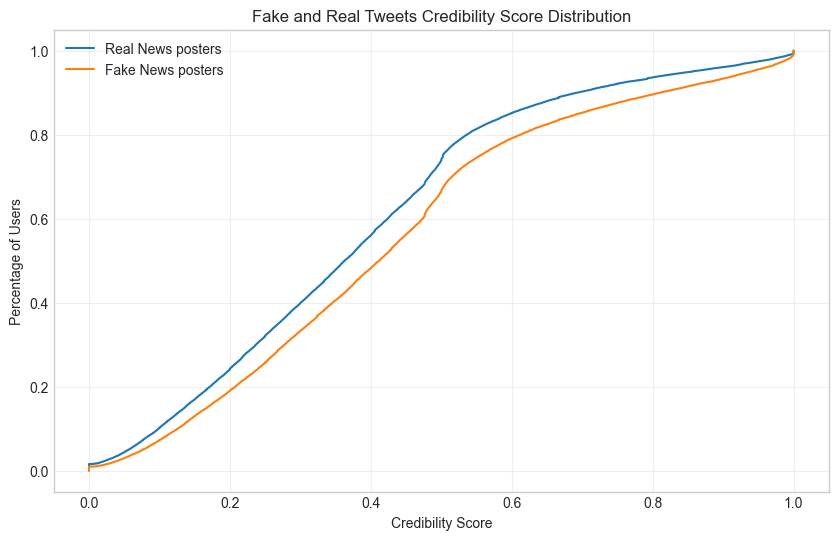

In [154]:
real_cred = df[df['majority_target'] == False]['cred']
fake_cred = df[df['majority_target'] == True]['cred']
# Compute ECDF (Empirical Cumulative Distribution Function)
x_real = np.sort(real_cred)
y_real = np.arange(1, len(x_real) + 1) / len(x_real)
x_fake = np.sort(fake_cred)
y_fake = np.arange(1, len(x_fake) + 1) / len(x_fake)
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_real, y_real, label='Real News posters')
plt.plot(x_fake, y_fake, label='Fake News posters')
plt.xlabel('Credibility Score')
plt.ylabel('Percentage of Users')
plt.title('Fake and Real Tweets Credibility Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

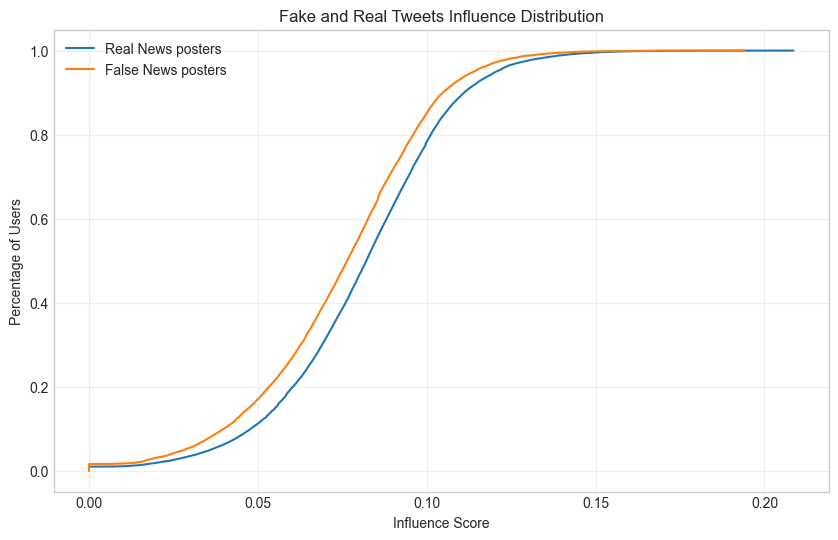

In [158]:
real_cred = df[df['majority_target'] == True]['normalize_influence']
fake_cred = df[df['majority_target'] == False]['normalize_influence']
# Compute ECDF (Empirical Cumulative Distribution Function)
x_real = np.sort(real_cred)
y_real = np.arange(1, len(x_real) + 1) / len(x_real)
x_fake = np.sort(fake_cred)
y_fake = np.arange(1, len(x_fake) + 1) / len(x_fake)
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_real, y_real, label='Real News posters')
plt.plot(x_fake, y_fake, label='False News posters')
plt.xlabel('Influence Score')
plt.ylabel('Percentage of Users')
plt.title('Fake and Real Tweets Influence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

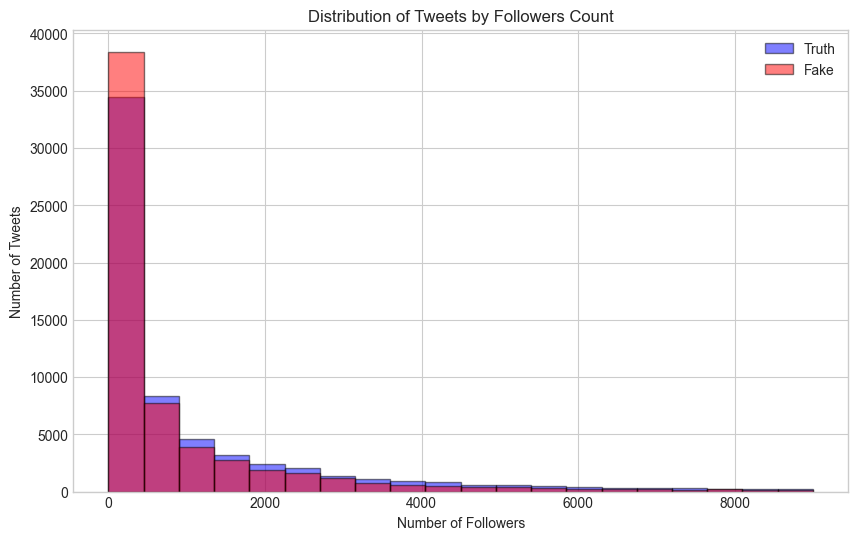

In [156]:
real_followers = df[df['majority_target'] == True]['followers_count']
fake_followers = df[df['majority_target'] == False]['followers_count']
plt.figure(figsize=(10, 6))
# Histogram with multiple bars (bins), stacked or overlaid. 
# 'alpha' makes them transparent so you can see overlap.
# range=(0, 10000) limits the X-axis to match your screenshot example
plt.hist(real_followers, bins=20, range=(0, 9000), alpha=0.5, color='blue', label='Truth', edgecolor='black')
plt.hist(fake_followers, bins=20, range=(0, 9000), alpha=0.5, color='red', label='Fake', edgecolor='black')
plt.xlabel('Number of Followers')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets by Followers Count')
plt.legend()
plt.show()

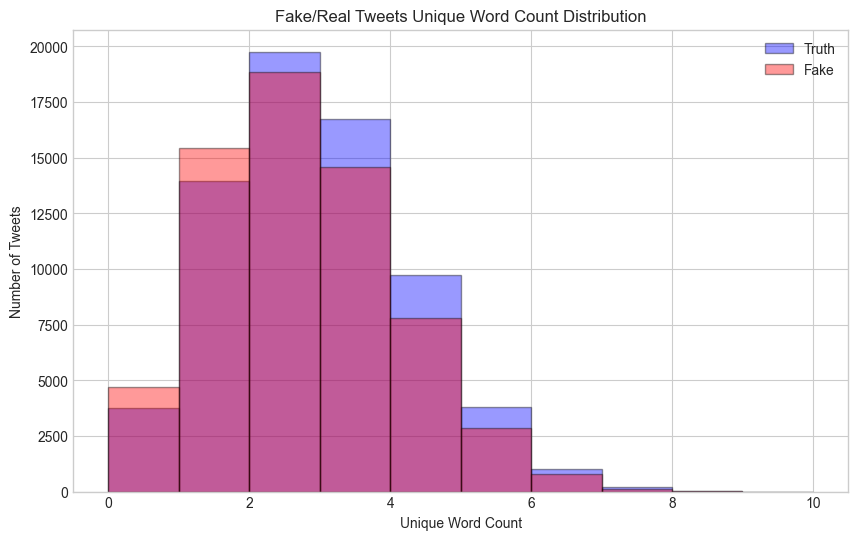

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assumptions: 'unique_count' is the column for unique word counts
# 'majority_target'==True is Fake, False is Real.
real_unique = df[df['majority_target'] == True]['unique_count']
fake_unique = df[df['majority_target'] == False]['unique_count']
plt.figure(figsize=(10, 6))
# The image shows buckets 0-9 roughly
plt.hist(real_unique, bins=range(0, 11), alpha=0.4, label='Truth', color='blue', edgecolor='black')
plt.hist(fake_unique, bins=range(0, 11), alpha=0.4, label='Fake', color='red', edgecolor='black')
plt.xlabel('Unique Word Count')
plt.ylabel('Number of Tweets')
plt.title('Fake/Real Tweets Unique Word Count Distribution')
plt.legend()
plt.show()